# ***Dataset Thresholding***

This notebook shows the thresholding of the dataset. We apply thresholding
to an MSI in order to separate tissue spectra's from all spectra's.

### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook:

In [1]:
import os
import numpy as np
from skimage import (filters)
from pyimzml.ImzMLParser import ImzMLParser, getionimage
from matplotlib import pyplot as plt
from typing import Tuple

%matplotlib inline

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [5]:
# Define folder that contains the dataset and files
DHG_PATH = "C:/Users/Leor/Desktop/Thesis/DHG"
# Define folder that contains the dataset
DATA_IN_PATH = f"{DHG_PATH}/preprocessed"

### ***Define function to try all treshould methods***

Next, let's define a function to try all treshould methods on given image:

In [3]:
def try_all_threshold(img: np.ndarray, figsize: Tuple[int, int],
                      blur: bool) -> Tuple[plt.Figure, np.ndarray]:
  """ Function to return a figure comparing the outputs of different
  thresholding methods.
  
  Args:
    img (np.ndarray): Grayscale input image.
    figsize (Tuple[int, int]): Figure size (in inches).
    blur (bool): Boolean to indicate whether to apply 
      smoothing\bluring to image before thresholding.
    
  Returns:
    [Tuple[plt.Figure, np.ndarray]]: Matplotlib figure and axes.
  
  """
  # create subplot
  fig, axes = plt.subplots(ncols=9, sharex=True, sharey=True, figsize=figsize)

  # apply gaussian blur to image
  smooth = filters.gaussian(img, sigma=0.5) if blur else img

  # threshold
  thresh_isodata = filters.threshold_isodata(smooth)
  thresh_li = filters.threshold_li(smooth)
  thresh_mean = filters.threshold_mean(smooth)
  thresh_min = filters.threshold_minimum(smooth)
  thresh_otsu = filters.threshold_otsu(smooth)
  thresh_triangle = filters.threshold_triangle(smooth)
  thresh_yen = filters.threshold_yen(smooth)
  tresh_median = np.median(smooth)

  # add each subplot
  axes[0].imshow(img, cmap='viridis')
  axes[0].set_title('Original')

  axes[1].imshow(smooth > thresh_isodata, cmap=plt.cm.gray)
  axes[1].set_title('Isodata')

  axes[2].imshow(smooth > thresh_li, cmap=plt.cm.gray)
  axes[2].set_title('Li')

  axes[3].imshow(smooth > thresh_mean, cmap=plt.cm.gray)
  axes[3].set_title('Mean')

  axes[4].imshow(smooth > thresh_min, cmap=plt.cm.gray)
  axes[4].set_title('Minimum')

  axes[5].imshow(smooth > thresh_otsu, cmap=plt.cm.gray)
  axes[5].set_title('Otsu')

  axes[6].imshow(smooth > thresh_triangle, cmap=plt.cm.gray)
  axes[6].set_title('Triangle')

  axes[7].imshow(smooth > thresh_yen, cmap=plt.cm.gray)
  axes[7].set_title('Yen')

  axes[8].imshow(smooth > tresh_median, cmap=plt.cm.gray)
  axes[8].set_title('Median')

  # remove axis from each subplot
  for ax in axes:
    ax.axis('off')

  # return plot
  return fig, axes

### ***Get all MSI names:***

Next, let's get all the MSI names from dataset path:

In [6]:
# Get all MSI names
msi_names = np.asarray(
    [f for f in os.listdir(DATA_IN_PATH) if f.endswith('.imzML')])

### ***Trehsould each MSI:***

Next, let's treshould each MSI to see what technique is best:

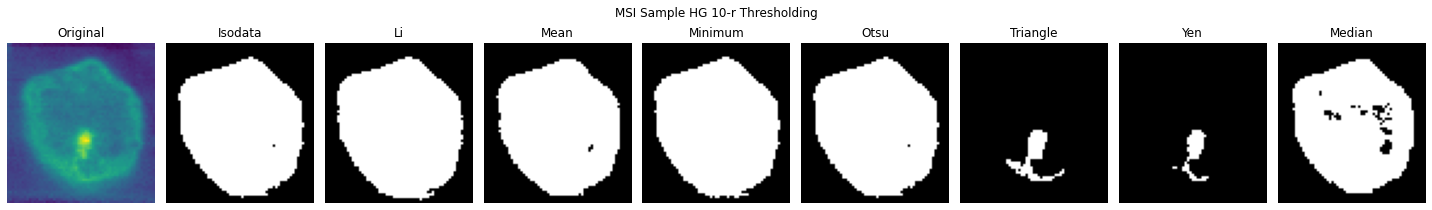

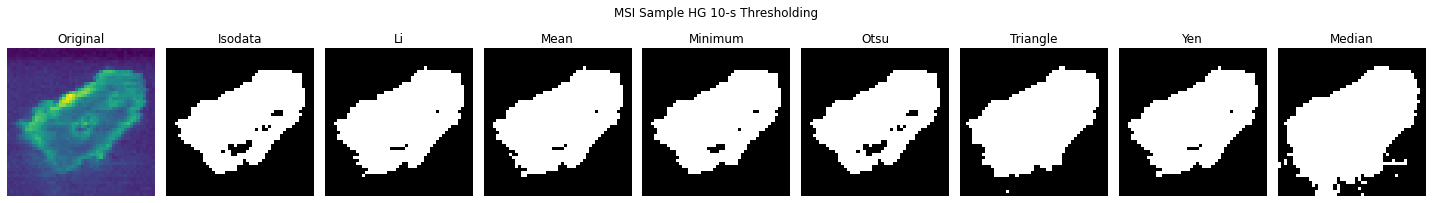

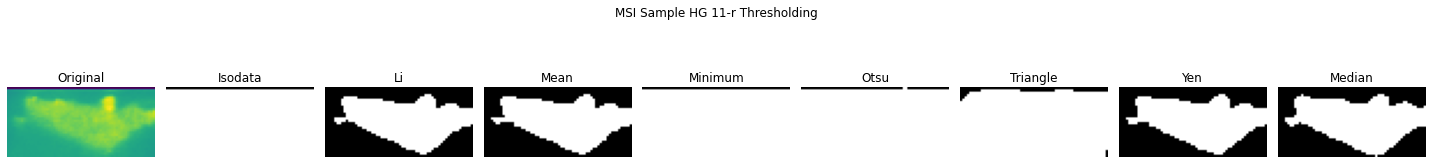

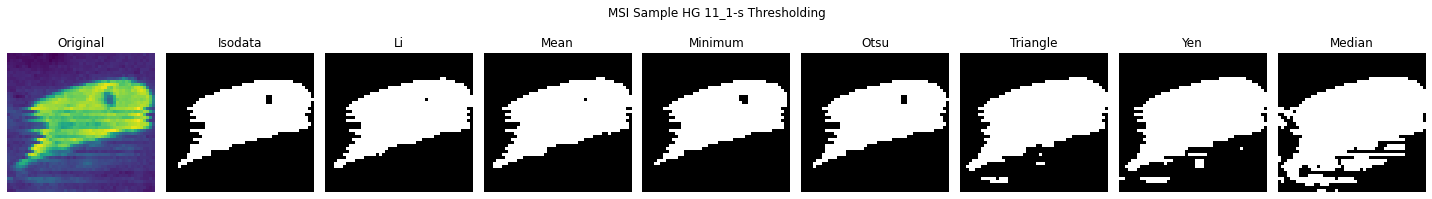

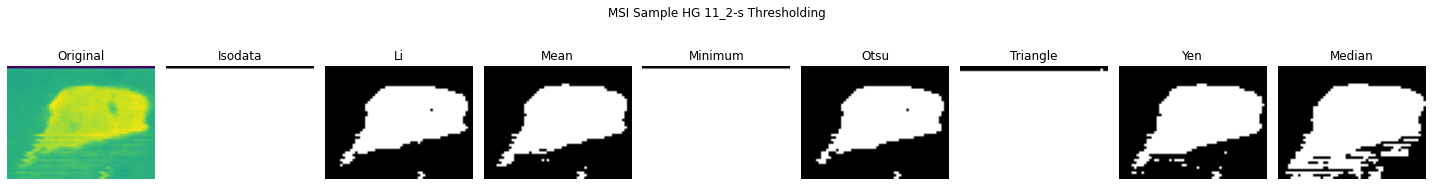

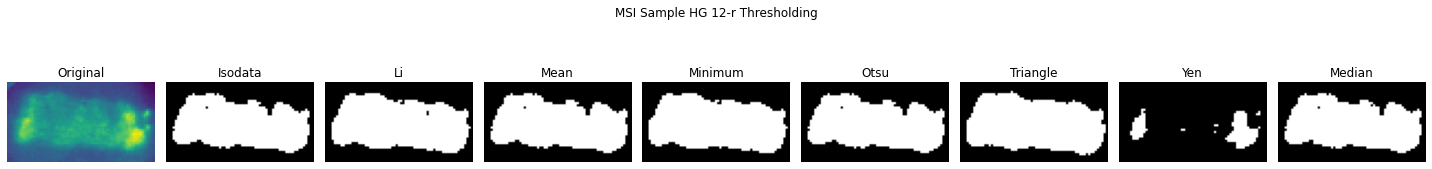

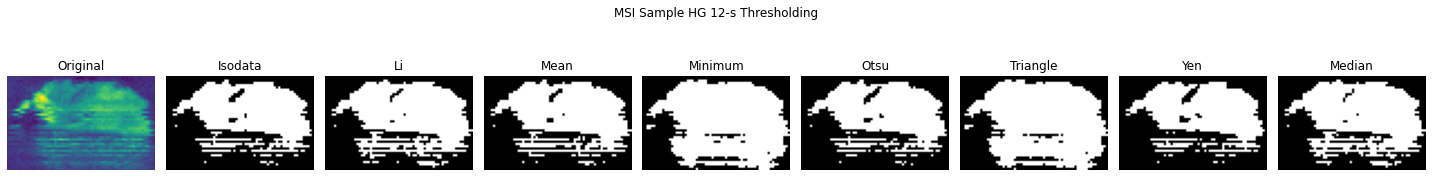

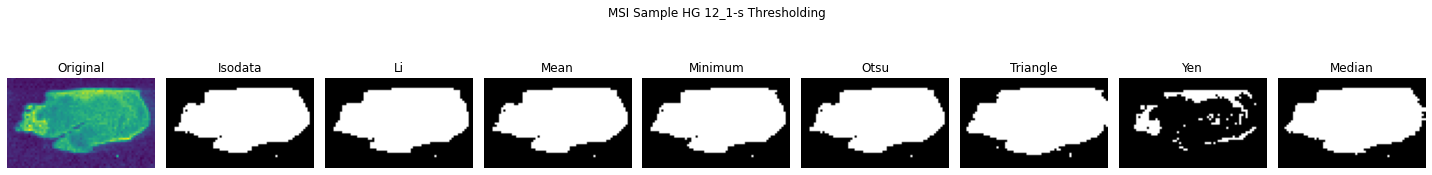

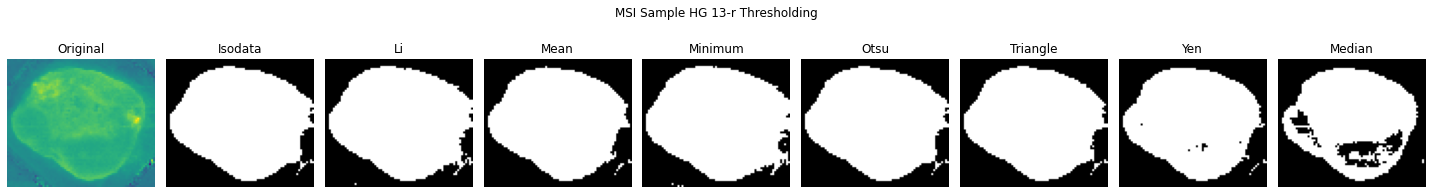

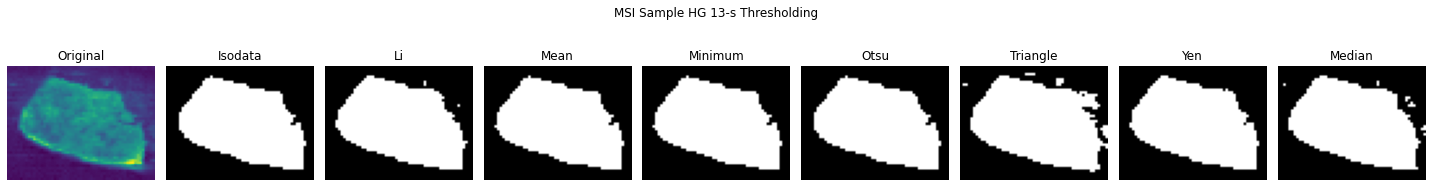

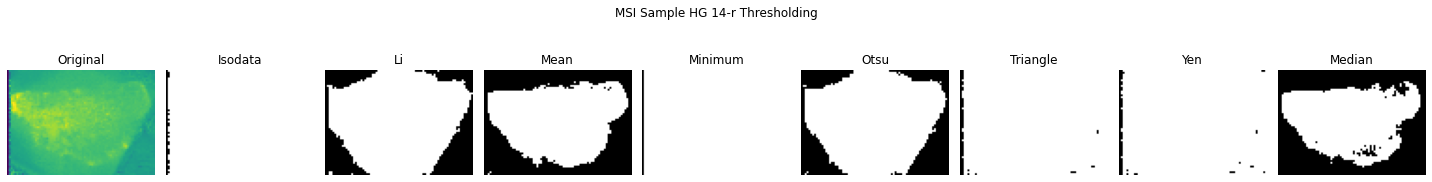

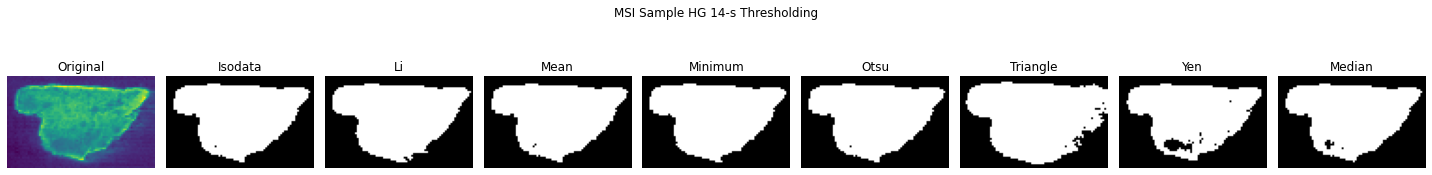

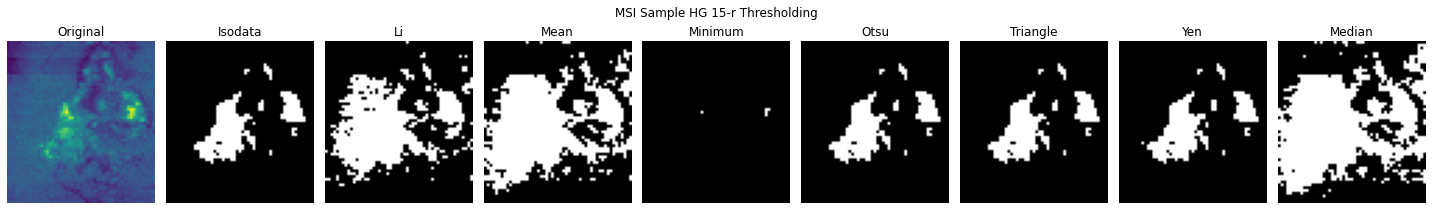

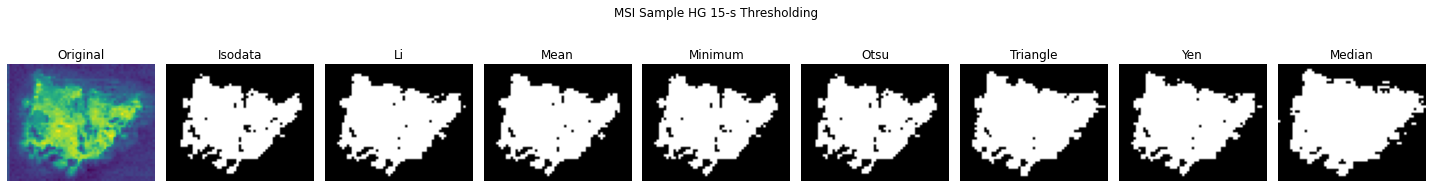

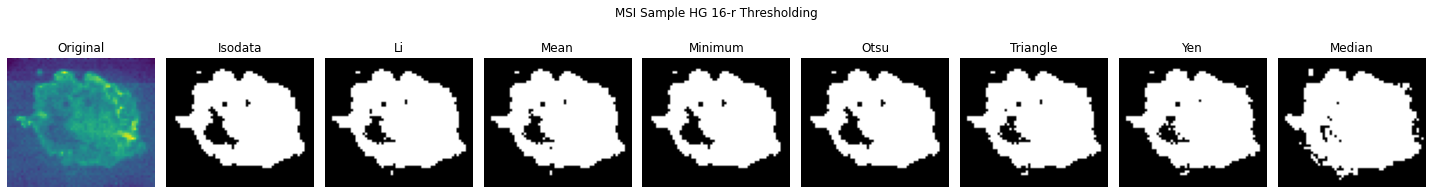

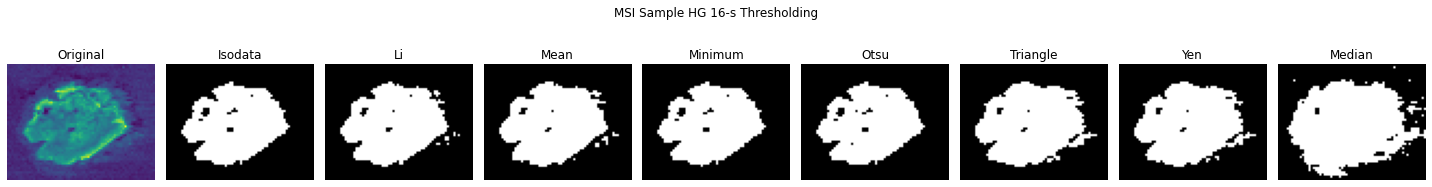

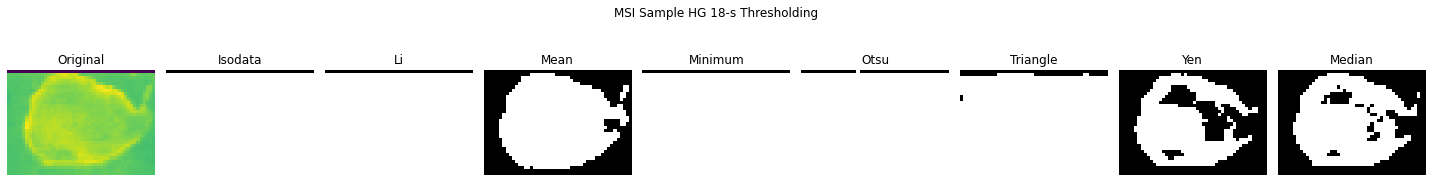

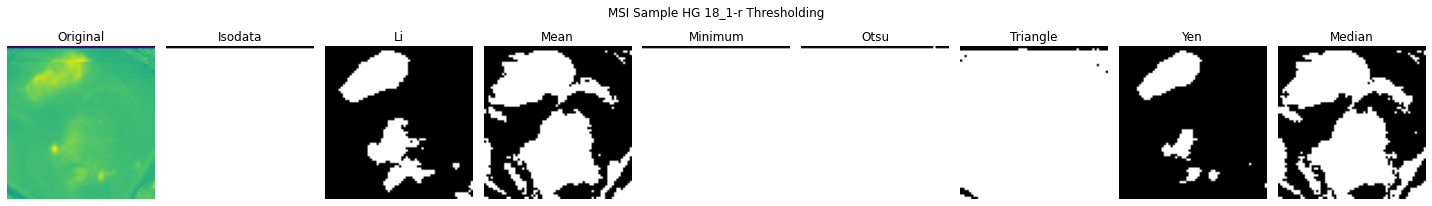

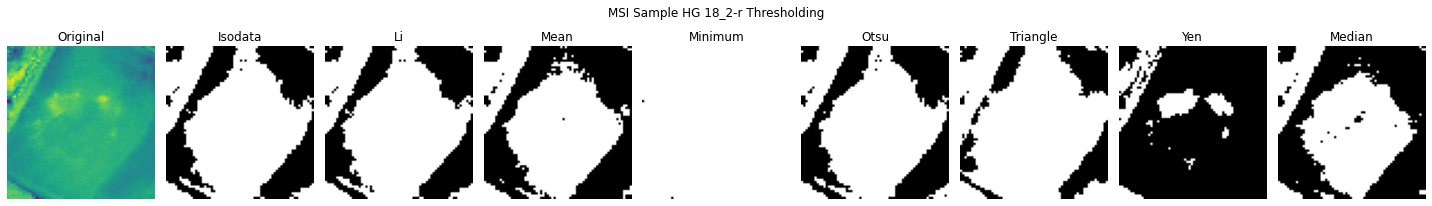

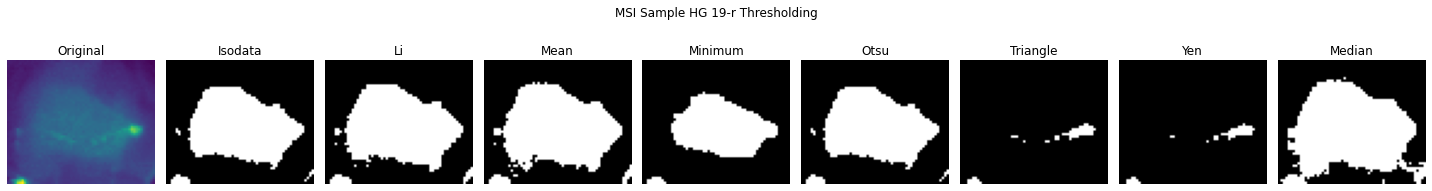

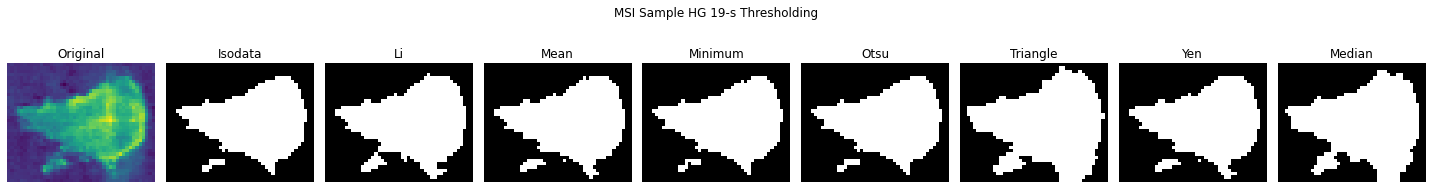

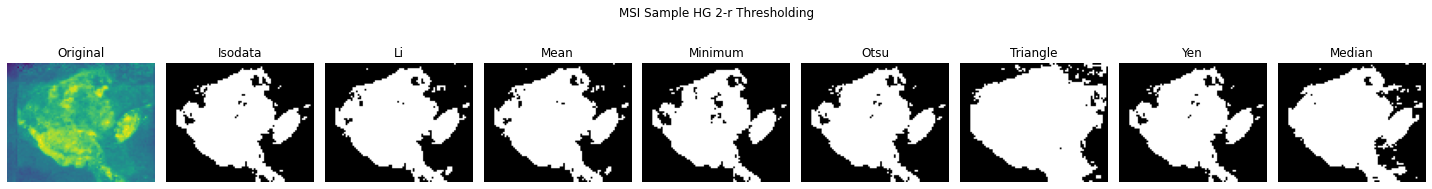

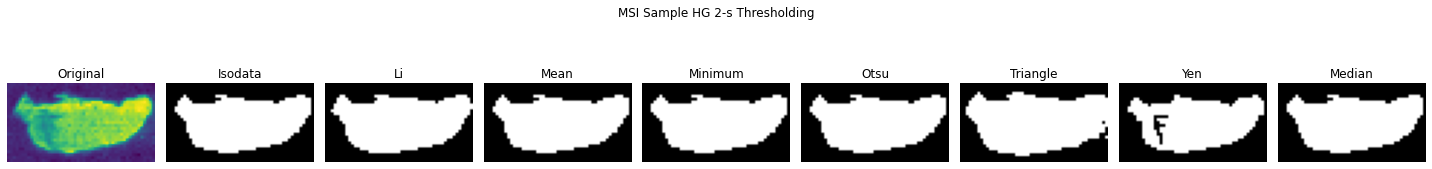

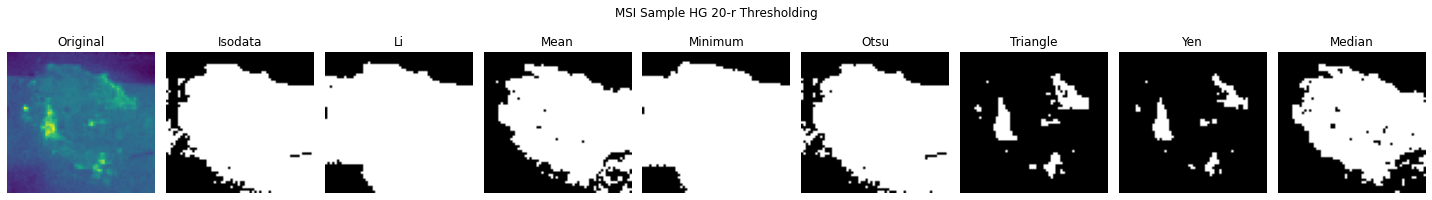

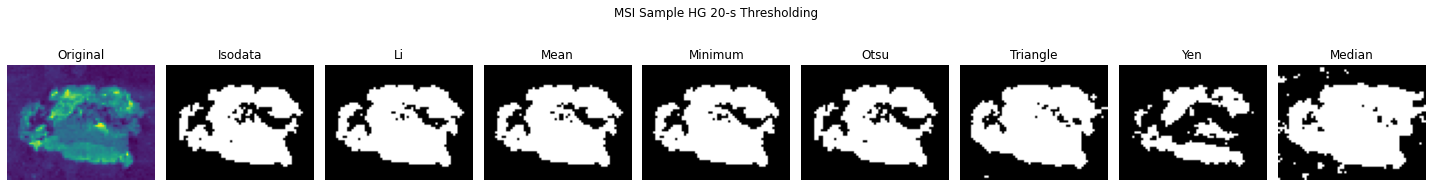

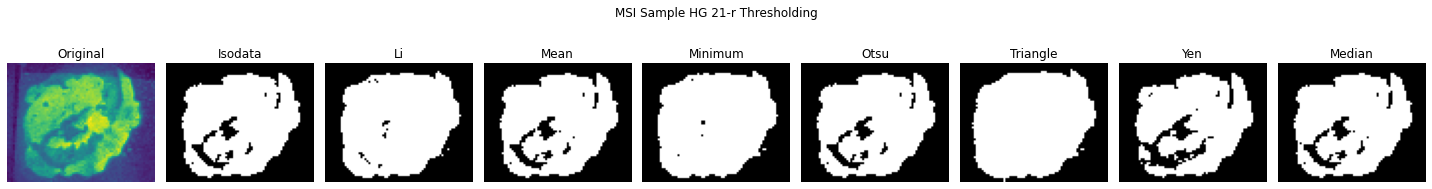

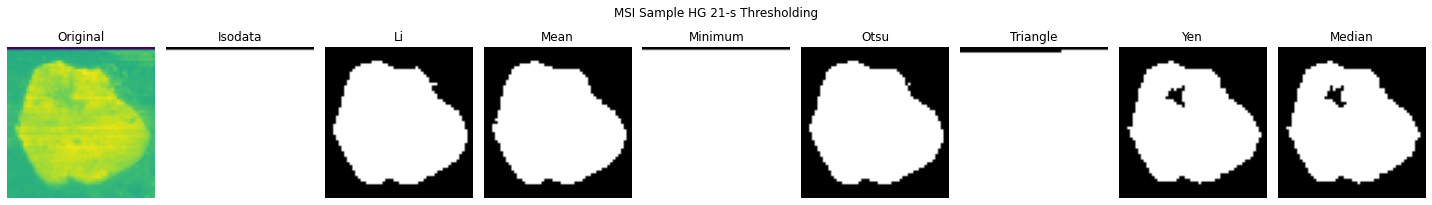

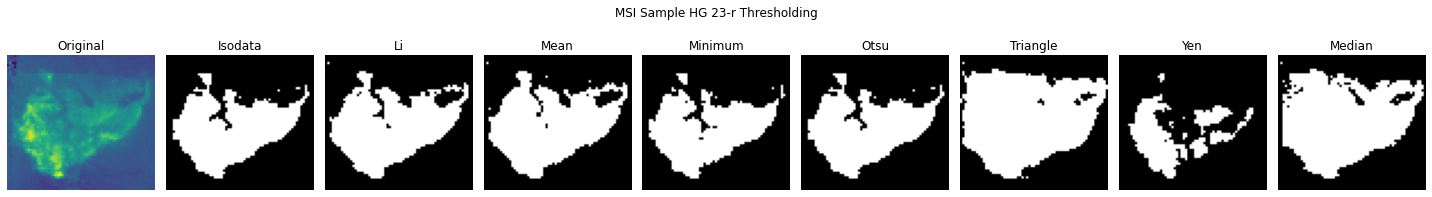

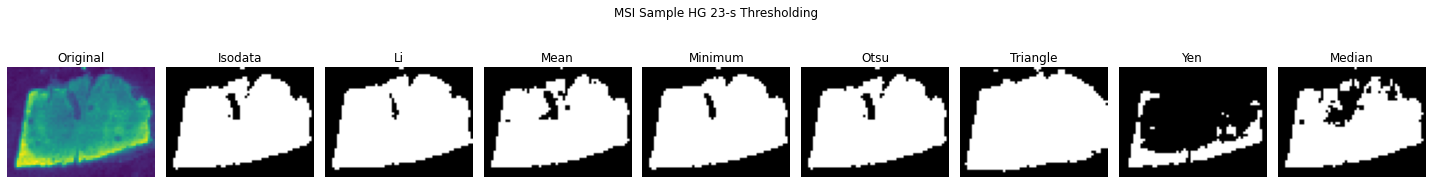

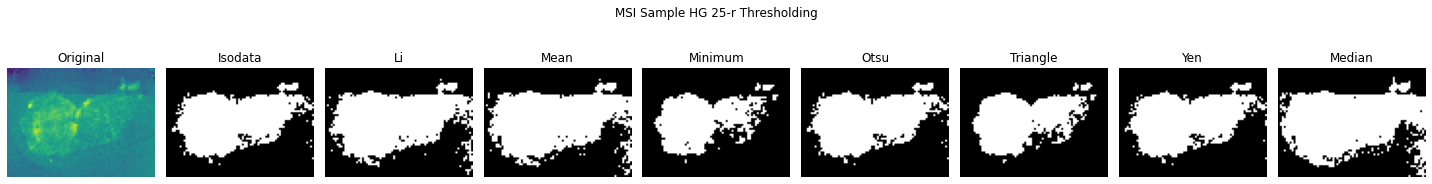

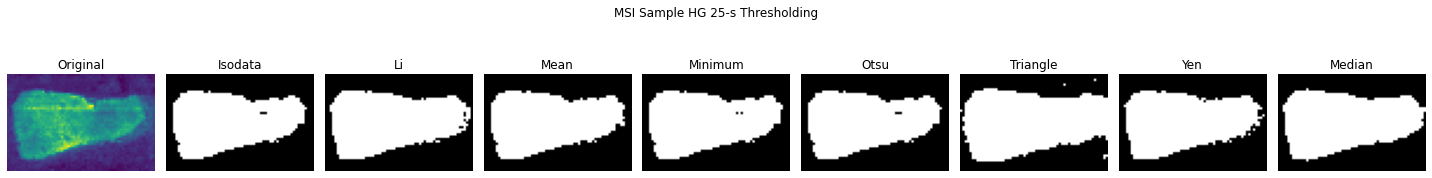

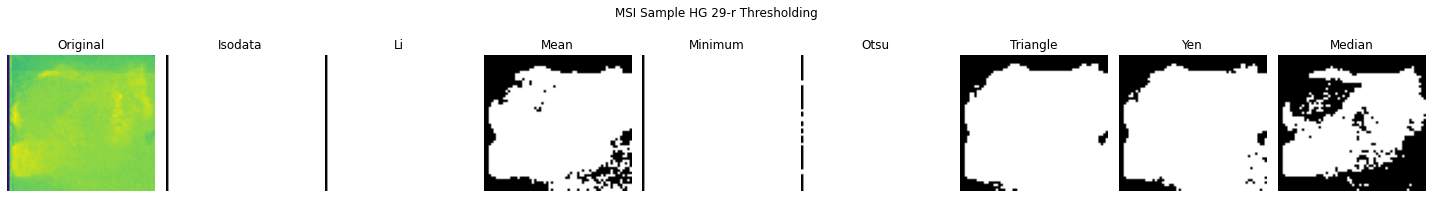

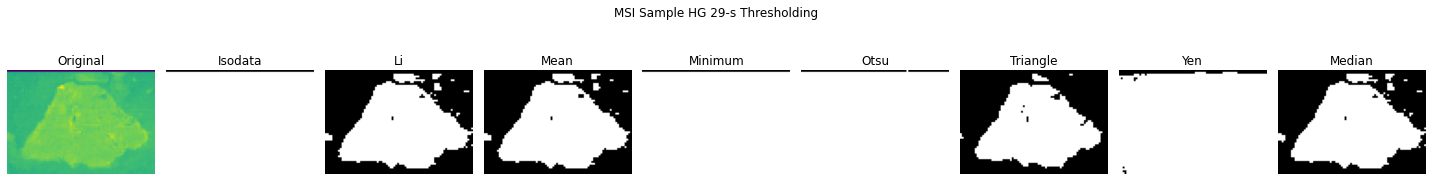

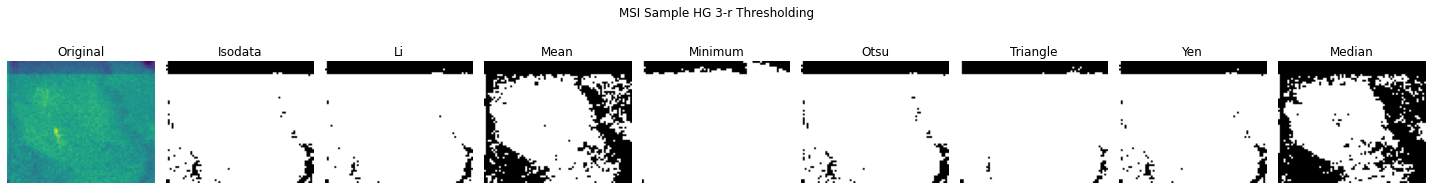

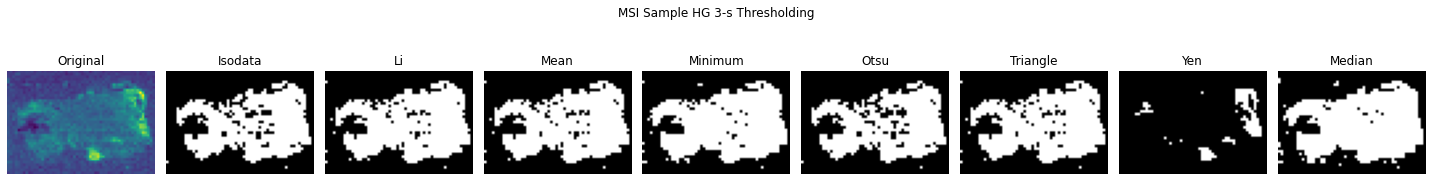

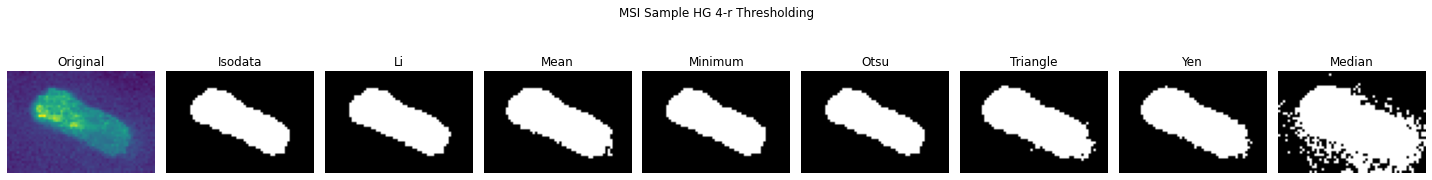

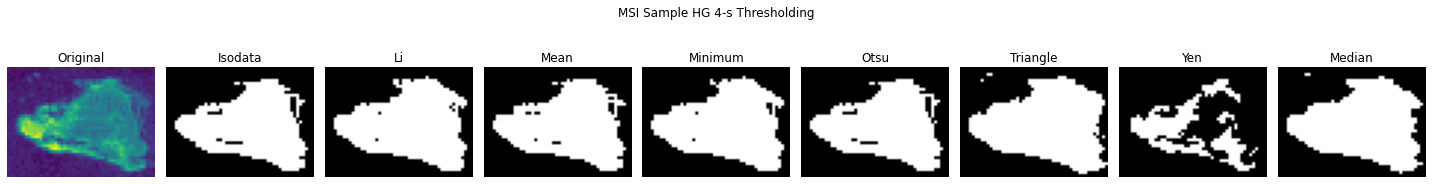

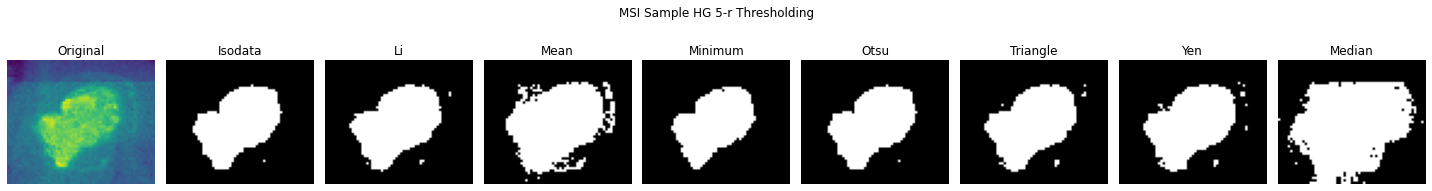

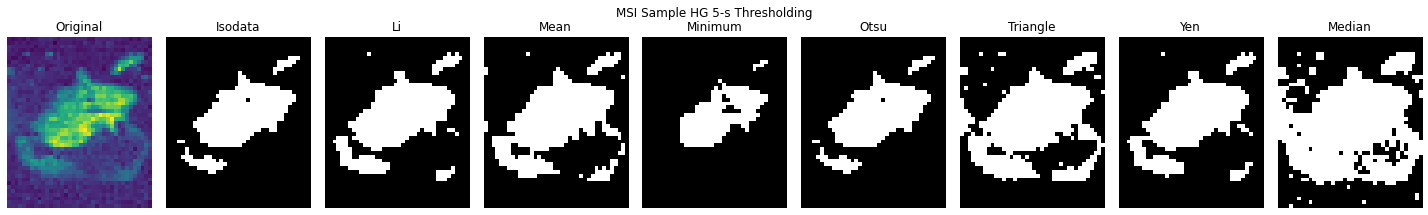

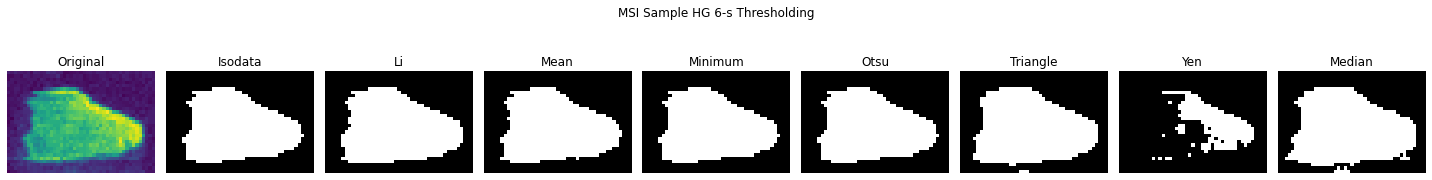

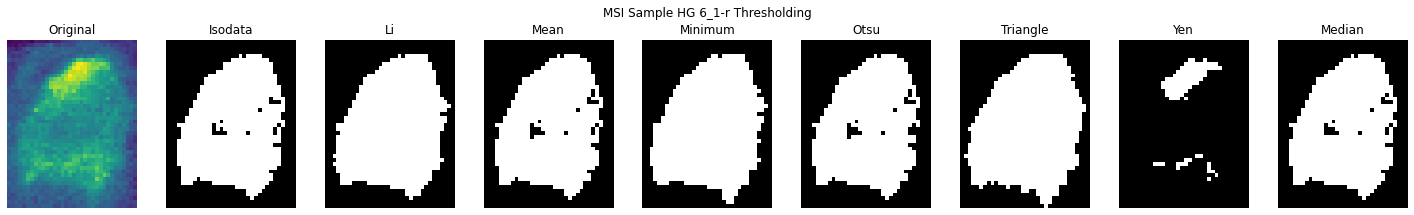

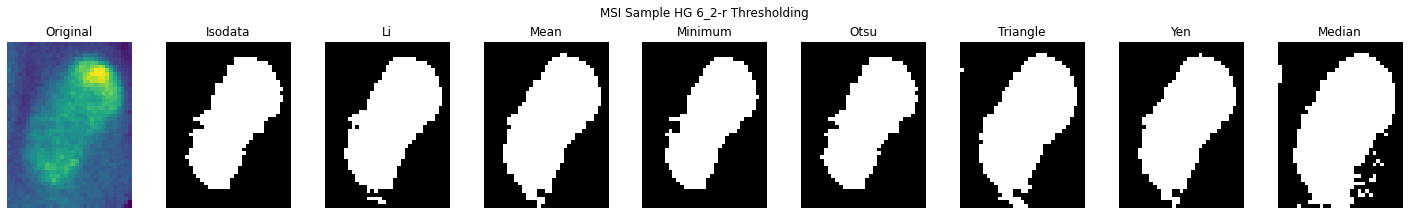

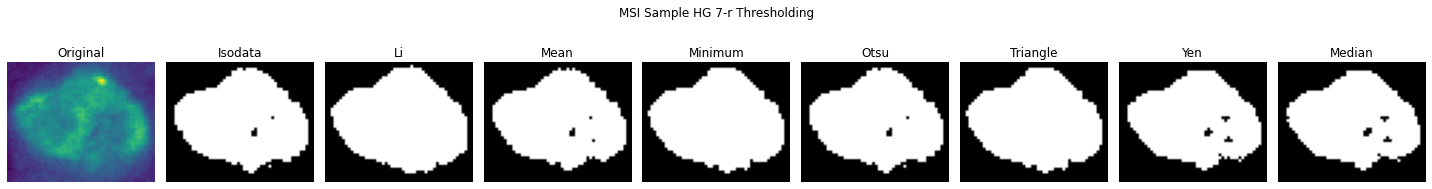

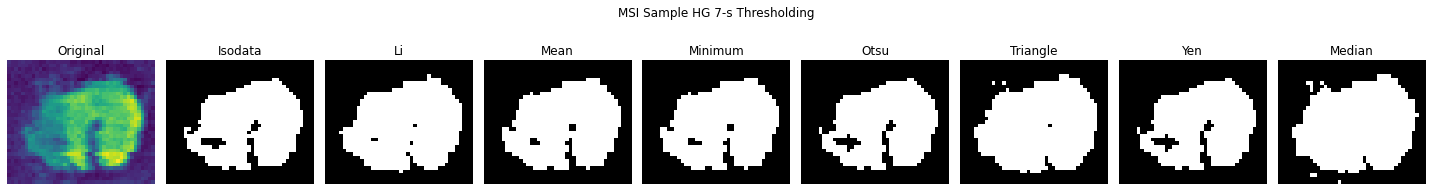

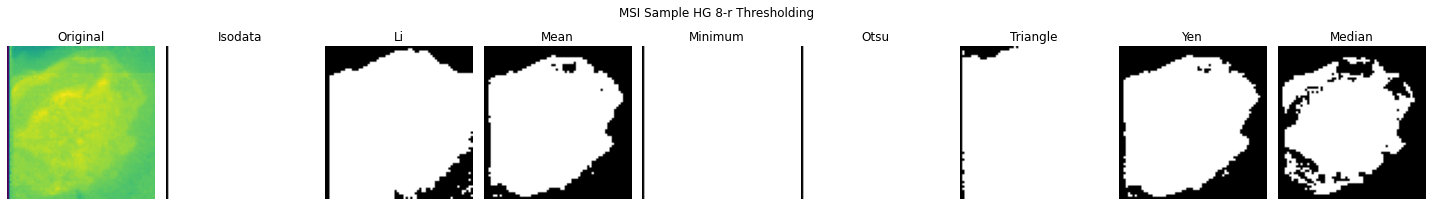

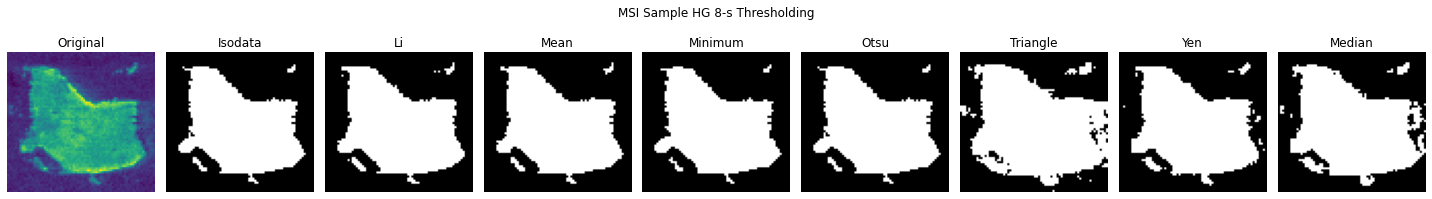

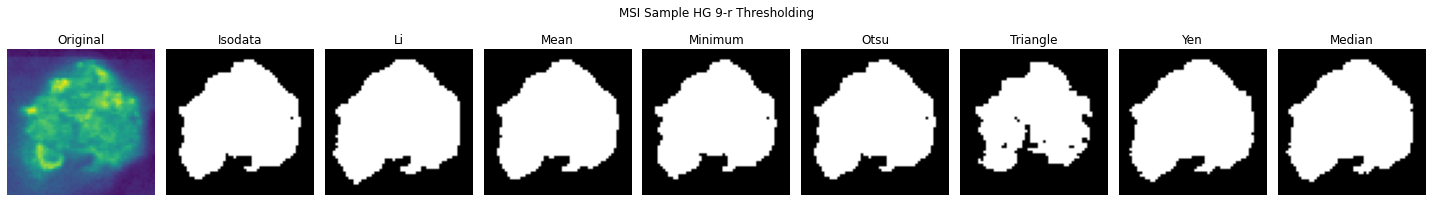

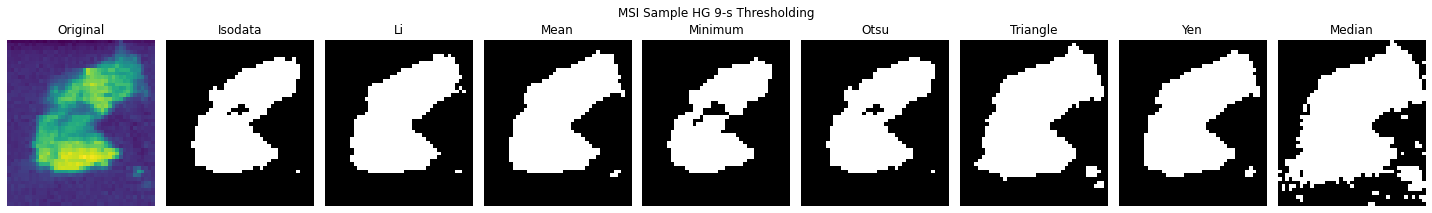

In [7]:
# Loop over each MSI name
for msi_name in msi_names:
  # Parse the MSI file
  with ImzMLParser(os.path.join(DATA_IN_PATH, msi_name)) as reader:
    # Get local TIC image of msi in mz region [600, 900]
    local_tic_img = getionimage(reader, 750, tol=150)

    # Get all thresholding algorithms outputs
    fig, ax = try_all_threshold(local_tic_img, figsize=(20, 3), blur=True)

    # plot thresholding algorithms outputs
    fig.suptitle(f"MSI Sample {msi_name.split('.')[0]} Thresholding")
    plt.tight_layout()
    plt.show()